In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import sklearn as skl
import scipy.stats as stats
import sys
local_rel_path = '../data/'
sys.path.insert(0, local_rel_path)
import nytimes
import importlib
import models
import features
importlib.reload(models)
importlib.reload(features)


import kinsa
import pandas as pd

In [8]:
# get the data in

state_df, county_df = nytimes.get_nyt_data()

unique_county_state = county_df.groupby(['county', 'state']).size().reset_index().rename(columns={0:'count'})
unique_county_state.to_csv('unique_county_state_pairs.csv')

county_cases_ts = nytimes.convert_county_df_to_ts(county_df, quantity='cases')
county_deaths_ts = nytimes.convert_county_df_to_ts(county_df, quantity='deaths')
county_fips = nytimes.convert_county_df_to_ts(county_df, quantity='fips')

state_cases_ts = nytimes.convert_state_df_to_ts(state_df, quantity='cases')
state_deaths_ts = nytimes.convert_state_df_to_ts(state_df, quantity='deaths')

def preprocess_df(df):
    
    # drop county, state columns if exist
    df = df.drop(columns=['county', 'state'], errors='ignore')
    # fill nas with zeros
    df = df.fillna(0)
    # replace column indices with datetime objects
    df = df.rename(
        columns=lambda str_date: dt.datetime.strptime(str_date, '%m/%d/%y'))
    
    return df

# do standard preprocessing below:
state_cases_ts = preprocess_df(state_cases_ts)
state_deaths_ts = preprocess_df(state_deaths_ts)

county_cases_ts = preprocess_df(county_cases_ts)
county_deaths_ts = preprocess_df(county_deaths_ts)


In [32]:
# demonstrate base forecast for Middlesex, Massachusetts

#demo_county = ('California', 'Kern')

path = 'output'
if not os.path.exists(path):
    os.makedirs(path)

state_county_pair_data = pd.read_csv('unique_county_state_pairs.csv',header = 0)[['county', 'state']]
# iterate over rows with iterrows()
for index, row in state_county_pair_data.iterrows():
    # access data using column names
    state = row['state']
    county = row['county']
    
    state_path = os.path.join(path, state)
    if not os.path.exists(state_path):
        os.makedirs(state_path)

    demo_county = (state, county )

    demo_ts = county_cases_ts.loc[demo_county , :].copy()
    demo_ts_daily = demo_ts.diff()
    # since we are demonstrating a base, not rolling forecast, shorten the 
    # time series to the relevant portion, i.e. where case count is large
    demo_ts_daily_short = demo_ts_daily.loc[demo_ts > 10]
    # now implement data checks, i.e. make sure daily data is positive
    demo_ts_daily_short = demo_ts_daily_short*(demo_ts_daily_short>=0)

    print()

    if (demo_ts_daily_short.size > 0):
        # now compute the forecasts
        target_date_range = pd.date_range(demo_ts_daily_short.index[0], 
                                        demo_ts_daily_short.index[-1]+dt.timedelta(days=21))
        out = models.base_forecast_linear(demo_ts_daily_short, target_date_range=target_date_range) #point
        out80 = models.base_forecast_linear(demo_ts_daily_short, quantile=0.8, target_date_range=target_date_range) # upper quantile
        out20 = models.base_forecast_linear(demo_ts_daily_short, quantile=0.2, target_date_range=target_date_range) # lower quantile

        # writing to a CSV file
        filename_prefix = state + '_' + county  + '_'
        out_filename = filename_prefix + 'out.csv'
        out80_filename = filename_prefix + 'out80.csv'
        out20_filename = filename_prefix + 'out20.csv'

        out_path = os.path.join(state_path, out_filename) 
        out80_path = os.path.join(state_path, out80_filename) 
        out20_path = os.path.join(state_path, out20_filename) 

        out.to_csv(out_path, index=True)
        out80.to_csv(out80_path, index=True)
        out20.to_csv(out20_path, index=True)

    # out.to_csv('outTEST_SC_'+str(index), index=True)


ject were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/thilankamunasinghe/isolatCovid19/isolat-public/src/models.py:67: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  predict_feats_scaled = scaler.transform(predict_feats)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transfor

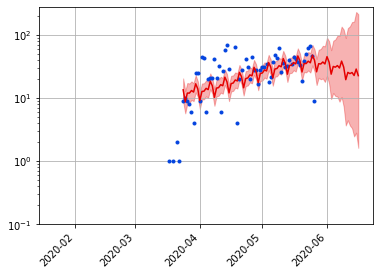

In [42]:
# plot stuff nicely
def my_format_dates(ax):
    for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            
fig, ax  = plt.subplots()
ax.plot(demo_ts_daily, color='xkcd:blue', marker='.', linestyle='')
ax.plot(out, color='xkcd:red')
ax.grid()
ax.fill_between(out.index, 
               out20, out80, 
               where=out20<out80,
               color='xkcd:red',
               alpha=0.3)

#ax.plot(out90, ':', color='xkcd:red', alpha=0.7)
#ax.plot(out10, ':', color='xkcd:red', alpha=0.7)
ax.set_yscale('log')
ax.set_ylim( (1e-1, 4*demo_ts_daily_short.max()))
my_format_dates(ax)

In [ ]:
importlib.reload(models)
importlib.reload(features)

In [ ]:
county_cases_ts.loc['California']

In [ ]:
out = scaled_arr
out[0, 0] = 2
print(  out[0, 0], scaled_arr[0, 0])

In [43]:
import scipy.stats as spstats
spstats.norm.ppf(0.2)

-0.8416212335729142

In [44]:
#function to merge the nyt and kinsa df
def enrich_nyt_kinsa(df,kinsa_df):
    
    # standardize date format
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
    
    #create a key to join the data (date + state + county)
    df['key'] =  df['date'].map(str) + df['state'].map(str) + df['county'].map(str)

    df = df.sort_values(by=['key'], ascending=True)
    
    #standardize date format
    kinsa_df['date'] = pd.to_datetime(kinsa_df['date'], format='%m/%d/%y')

    #strip out the string 'county'
    kinsa_df['region_name'] = [x.replace(' County','') for x in kinsa_df['region_name']]

    kinsa_df.reset_index(drop=True, inplace=True)
    
    #create the key to join on (date + state + county)
    kinsa_df['key'] =  kinsa_df['date'].map(str) + kinsa_df['state'].map(str) + kinsa_df['region_name'].map(str)

    #merge
    df = df.merge(kinsa_df, left_on='key', right_on='key')

    
    return df

In [45]:
## get the kinsa data
dfc_k = kinsa.get_kinsa_data()

## this adds the kinsa data to the nyt df
df_enriched = enrich_nyt_kinsa(county_df,dfc_k)




Could not download data from url https://static.kinsahealth.com/AK_data.json
Could not download data from url https://static.kinsahealth.com/HI_data.json


In [19]:
df_enriched.head(50)

,date_x,county,state_x,fips,cases,deaths,key,region_id,region_name,region_type,state_y,observed_ili,atypical_ili,atypical_ili_delta,anomaly_fevers,raw_anomaly_fevers,forecast_expected,forecast_lower,forecast_upper,date_y
0,2020-02-16,Maricopa,Arizona,04013,1,0,2020-02-16 00:00:00ArizonaMaricopa,04013,Maricopa,county,Arizona,5.470399,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
1,2020-02-16,Los Angeles,California,06037,1,0,2020-02-16 00:00:00CaliforniaLos Angeles,06037,Los Angeles,county,California,6.727377,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
2,2020-02-16,Orange,California,06059,1,0,2020-02-16 00:00:00CaliforniaOrange,06059,Orange,county,California,7.131821,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
3,2020-02-16,San Diego,California,06073,1,0,2020-02-16 00:00:00CaliforniaSan Diego,06073,San Diego,county,California,7.011039,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
4,2020-02-16,San Francisco,California,06075,2,0,2020-02-16 00:00:00CaliforniaSan Francisco,06075,San Francisco,county,California,6.513171,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
5,2020-02-16,Santa Clara,California,06085,2,0,2020-02-16 00:00:00CaliforniaSanta Clara,06085,Santa Clara,county,California,6.671759,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
6,2020-02-16,Cook,Illinois,17031,2,0,2020-02-16 00:00:00IllinoisCook,17031,Cook,county,Illinois,8.181504,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
7,2020-02-16,Suffolk,Massachusetts,25025,1,0,2020-02-16 00:00:00MassachusettsSuffolk,25025,Suffolk,county,Massachusetts,8.759137,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
8,2020-02-16,Bexar,Texas,48029,2,0,2020-02-16 00:00:00TexasBexar,48029,Bexar,county,Texas,6.523244,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16
9,2020-02-16,Snohomish,Washington,53061,1,0,2020-02-16 00:00:00WashingtonSnohomish,53061,Snohomish,county,Washington,5.112695,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2020-02-16


In [20]:
##we can use the nytime converter function to convert the kinsa data too!

dfc_k = dfc_k.rename(columns={"region_name": "county"})

ts_kinsa = nytimes.convert_county_df_to_ts(dfc_k, quantity='observed_ili')
ts_kinsa.head(15)

date                county    state  2020-02-16 00:00:00  2020-02-17 00:00:00  \
Alabama Autauga    Autauga  Alabama             5.288498             5.491339   
        Baldwin    Baldwin  Alabama             4.403135             4.528170   
        Barbour    Barbour  Alabama             4.441221             4.436546   
        Bibb          Bibb  Alabama             5.401230             5.611932   
        Blount      Blount  Alabama             4.799060             4.875495   
        Bullock    Bullock  Alabama             4.769264             4.875755   
        Butler      Butler  Alabama             4.733287             5.037480   
        Calhoun    Calhoun  Alabama             4.948421             4.847499   
        Chambers  Chambers  Alabama             4.895264             4.950134   
        Cherokee  Cherokee  Alabama             5.028504             4.954165   
        Chilton    Chilton  Alabama             5.196600             5.420372   
        Choctaw    Choctaw  Alabama             5.236716             5.420684   
        Clarke      Clarke  Alabama             4.572584             4.873026   
        Clay          Clay  Alabama             5.018522             4.849942   
        Cleburne  Cleburne  Alabama             5.196277             5.098488   

date              2020-02-18 00:00:00  2020-02-19 00:00:00  \
Alabama Autauga              5.258497             5.684253   
        Baldwin              4.598274             5.166475   
        Barbour              4.558205             4.846622   
        Bibb                 5.246376             5.729228   
        Blount               4.347592             4.924024   
        Bullock              4.718724             5.079472   
        Butler               4.903939             5.315801   
        Calhoun              4.604234             5.094955   
        Chambers             4.528567             4.786569   
        Cherokee             4.338720             4.672470   
        Chilton              5.108198             5.677729   
        Choctaw              4.894113             5.396889   
        Clarke               4.864118             5.435746   
        Clay                 4.605055             5.232819   
        Cleburne             4.672441             4.852538   

date              2020-02-20 00:00:00  2020-02-21 00:00:00  \
Alabama Autauga              5.656970             5.433901   
        Baldwin              4.806828             4.481217   
        Barbour              4.825997             4.685856   
        Bibb                 5.880280             5.723700   
        Blount               5.065264             5.116304   
        Bullock              5.018287             4.931610   
        Butler               5.293473             4.915977   
        Calhoun              4.987764             4.947536   
        Chambers             4.730648             4.649664   
        Cherokee             4.608722             4.719569   
        Chilton              5.745783             5.518817   
        Choctaw              5.140891             4.759987   
        Clarke               5.253261             4.859161   
        Clay                 5.126990             5.154925   
        Cleburne             4.779912             4.755002   

date              2020-02-22 00:00:00  2020-02-23 00:00:00  ...  \
Alabama Autauga              5.160662             5.100546  ...   
        Baldwin              4.640787             5.076373  ...   
        Barbour              4.689780             4.795581  ...   
        Bibb                 5.601711             5.243069  ...   
        Blount               4.947211             4.576656  ...   
        Bullock              4.779916             4.657681  ...   
        Butler               4.759933             4.873341  ...   
        Calhoun              4.580353             4.241951  ...   
        Chambers             4.599705             4.601216  ...   
        Cherokee             4.351428          